In [1]:
# !pip uninstall pillow
# !pip install pillow

In [2]:
import os
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from gan_model import Discriminator, Generator, PerceptualLoss
import tifffile as tiff
from torch.utils.tensorboard import SummaryWriter
import torchvision
from tqdm import tqdm
import pandas as pd
from torchvision.transforms import InterpolationMode
import torch

In [3]:
torch.cuda.empty_cache()

In [4]:
def normalize_to_uint8(image):
    """
    Normalize an image array to the range [0,255] and convert to uint8.
    """
    if image.max() - image.min() < 1e-8:
        return np.zeros(image.shape, dtype=np.uint8)
    image_norm = (image - image.min()) / (image.max() - image.min() + 1e-8)
    image_uint8 = (255 * image_norm).astype(np.uint8)
    return image_uint8

In [5]:
# Custom dataset for a WorldStrat-like folder structure.
class WorldStratDataset(Dataset):
    def __init__(self, lr_root, hr_root, lr_transform=None, hr_transform=None):
        """
        lr_root: path to low-resolution folder (e.g., lr_dataset_l2a)
        hr_root: path to high-resolution folder (e.g., hr_dataset)
        lr_transform: transforms applied to LR images.
        hr_transform: transforms applied to HR images.
        """
        self.lr_root = lr_root
        self.hr_root = hr_root
        self.lr_transform = lr_transform
        self.hr_transform = hr_transform
        self.image_pairs = []

        #open csv file with pd
        self.metadata = pd.read_csv('metadata.csv')


        # For each POI in lr_root, we assume a matching folder in hr_root.
        skipped = 0
        for poi in os.listdir(lr_root)[:2]:
            lr_poi_dir = os.path.join(lr_root, poi)
            hr_poi_dir = os.path.join(hr_root, poi)
            
            if os.path.isdir(lr_poi_dir) and os.path.isdir(hr_poi_dir):
                lr_folder = os.path.join(lr_poi_dir, "L2A")
                if not os.path.exists(lr_folder):
                    continue
                
                # Find all LR and HR images
                lr_files = sorted([f for f in os.listdir(lr_folder) if '-L2A' in f])
                hr_files = sorted([f for f in os.listdir(hr_poi_dir) if '_rgbn' in f])

                if not hr_files:
                    hr_files = sorted([f for f in os.listdir(hr_poi_dir) if '_rgb' in f])
                
                if lr_files and hr_files:
                    lr_paths = [os.path.join(lr_folder, f) for f in lr_files]
                    hr_path = os.path.join(hr_poi_dir, hr_files[0])  # Assuming one HR per set of LR
                    for lr_path in lr_paths:
                        if os.path.exists(lr_path) and os.path.exists(hr_path):
                            #find lr image metadata
                            lr_name = os.path.basename(lr_path)
                            lr_name = lr_name.split('-L2A')[0]
                            
                            lr_names = lr_name.split('-')
                            if len(lr_names) == 5:
                                lr_name = lr_names[0] + '-' + lr_names[1] + '-' + lr_names[2] + '-' + lr_names[3]
                                n = lr_names[4]
                            else:
                                lr_name = lr_names[0] + '-' + lr_names[1]
                                n = lr_names[2]

                            metadata = self.metadata[(self.metadata['filename'] == lr_name) & (self.metadata['n'] == int(n))]
                            cloud_cover = metadata['cloud_cover']
                            if int(cloud_cover) < 0.15:
                                self.image_pairs.append((lr_path, hr_path))
                            else:
                                skipped += 1

        print(f"Found {len(self.image_pairs)} image sets (HR + multiple LR).")
        print(f"Skipped {skipped} images due to cloud cover.")

    def __len__(self):
        return len(self.image_pairs)

    def __getitem__(self, idx):
        lr_path, hr_path = self.image_pairs[idx]
        # Read TIFF images.
        lr_image = tiff.imread(lr_path)
        hr_image = tiff.imread(hr_path)

        # Squeeze out singleton dimensions.
        lr_image = np.squeeze(lr_image)
        hr_image = np.squeeze(hr_image)

        # If images are in (channels, H, W) order, transpose them to (H, W, channels)
        if lr_image.ndim == 3 and lr_image.shape[0] in [1, 3, 4, 12]:
            lr_image = np.transpose(lr_image, (1, 2, 0))
        if hr_image.ndim == 3 and hr_image.shape[0] in [1, 3, 4, 12]:
            hr_image = np.transpose(hr_image, (1, 2, 0))
            
        # If the image has more than 4 channels, select the first 4 channels (e.g., RGB+NIR)
        if lr_image.ndim == 3 and lr_image.shape[2] > 4:
            lr_image = lr_image[:, :, [1,2,3,7]]
        if hr_image.ndim == 3 and hr_image.shape[2] > 4:
            hr_image = hr_image[:, :, :4]

        # --- Fix for LR images stored as GBR ---
        # If the low-res image has 3 channels (GBR) then swap to RGB.
        if lr_image.ndim == 3:
            if lr_image.shape[2] == 3:
                lr_image = lr_image[:, :, [2, 1, 0]]
            elif lr_image.shape[2] == 4:
                # Assume the first three channels are BGR and the fourth is alpha.
                lr_image = lr_image[:, :, [2, 1, 0, 3]]

        # --- Convert images to uint8 if necessary ---
        lr_image = np.ascontiguousarray(lr_image)
        hr_image = np.ascontiguousarray(hr_image)
        if lr_image.dtype != np.uint8:
            lr_image = normalize_to_uint8(lr_image)
        if hr_image.dtype != np.uint8:
            hr_image = normalize_to_uint8(hr_image)

        # Convert arrays to PIL images.
        mode_lr = "RGB" if lr_image.shape[2] == 3 else "RGBA"
        mode_hr = "RGB" if hr_image.shape[2] == 3 else "RGBA"
        lr_image = Image.fromarray(lr_image, mode=mode_lr)
        hr_image = Image.fromarray(hr_image, mode=mode_hr)

        if self.lr_transform:
            lr_image = self.lr_transform(lr_image)
        if self.hr_transform:
            hr_image = self.hr_transform(hr_image)
        return lr_image, hr_image

In [6]:
# Function to display a generated sample image's RGB and NIR channels.
def display_sample(generator, sample_lr, device):
    generator.eval()
    with torch.no_grad():
        # Prepare LR sample
        sample_lr = sample_lr.to(device).unsqueeze(0)  # shape: [1, C, H, W]
        
        # Generate HR output
        fake_hr = generator(sample_lr)  # expected output shape: [1, 4, H, W]
        fake_hr = fake_hr.squeeze(0).cpu()
        
        # Extract and normalize the generated images
        gen_rgb = fake_hr[:3, :, :].permute(2,1,0).numpy()
        gen_nir = fake_hr[3, :, :].numpy()
        
        gen_rgb = (gen_rgb * 0.5) + 0.5  # Unnormalize using the same mean and std as applied during preprocessing
        gen_nir = (gen_nir * 0.5) + 0.5
        
        # Prepare LR images for display
        sample_lr_cpu = sample_lr.squeeze(0).cpu()
        lr_rgb = sample_lr_cpu[:3, :, :].permute(1, 2, 0).numpy()
        lr_nir = sample_lr_cpu[3, :, :].numpy()
        
        lr_rgb = (lr_rgb * 0.5) + 0.5
        lr_nir = (lr_nir * 0.5) + 0.5
        # Create a merged figure with a 2x2 grid of subplots
        fig, axs = plt.subplots(2, 2, figsize=(10, 10))
        
        # First row: Generated HR images
        axs[0, 0].imshow(gen_rgb)
        axs[0, 0].set_title("Generated RGB Image")
        axs[0, 0].axis("off")
        
        axs[0, 1].imshow(gen_nir, cmap="gray")
        axs[0, 1].set_title("Generated NIR Channel")
        axs[0, 1].axis("off")
        
        # Second row: LR images
        axs[1, 0].imshow(lr_rgb)
        axs[1, 0].set_title("LR RGB Image")
        axs[1, 0].axis("off")
        
        axs[1, 1].imshow(lr_nir, cmap="gray")
        axs[1, 1].set_title("LR NIR Channel")
        axs[1, 1].axis("off")
        
        plt.tight_layout()
        plt.show()

In [7]:
adversarial_loss_factor = 0.001  # Keeps GAN training stable
perceptual_loss_factor = 0.2  # Emphasizes perceptual quality
content_loss_factor = 1.0  # Ensures structural similarity

def train_gan(generator, discriminator, dataloader, g_optimizer, d_optimizer,
              adversarial_criterion, perception_criterion, content_criterion, device, epoch, writer):
    
    generator.train()
    discriminator.train()
    running_d_loss = 0.0
    running_g_loss = 0.0
    n_batches = len(dataloader)

    # Wrap the dataloader with tqdm for a progress bar.
    progress_bar = tqdm(enumerate(dataloader), total=n_batches, desc=f"Training Epoch {epoch}")
    for batch_idx, (lr_imgs, hr_imgs) in progress_bar:

        low_resolution = lr_imgs.to(device)  # shape: [B, 3 or 4, H, W]
        high_resolution = hr_imgs.to(device)  # shape: [B, 4, H, W]

        # -----------------
        # Train Generator
        # -----------------

        real_labels = torch.ones((high_resolution.size(0), 1)).to(device)
        fake_labels = torch.zeros((high_resolution.size(0), 1)).to(device)

        g_optimizer.zero_grad()
        fake_high_resolution = generator(low_resolution)

        score_real = discriminator(high_resolution)
        score_fake = discriminator(fake_high_resolution)
        discriminator_rf = score_real - score_fake.mean()
        discriminator_fr = score_fake - score_real.mean()        

        adversarial_loss_rf = adversarial_criterion(discriminator_rf, fake_labels)
        adversarial_loss_fr = adversarial_criterion(discriminator_fr, real_labels)
        adversarial_loss = (adversarial_loss_fr + adversarial_loss_rf) / 2

        perceptual_loss = perception_criterion(high_resolution, fake_high_resolution)
        content_loss = content_criterion(fake_high_resolution, high_resolution)
        
        generator_loss = adversarial_loss * adversarial_loss_factor + \
                         perceptual_loss * perceptual_loss_factor + \
                         content_loss * content_loss_factor
        generator_loss.backward()
        g_optimizer.step()

        # -----------------
        # Train Discriminator
        # ------------------

        score_real = discriminator(high_resolution)
        score_fake = discriminator(fake_high_resolution.detach())

        discriminator_rf = score_real - score_fake.mean()
        discriminator_fr = score_fake - score_real.mean()
        adversarial_loss_rf = adversarial_criterion(discriminator_rf, real_labels)
        adversarial_loss_fr = adversarial_criterion(discriminator_fr, fake_labels)
        discriminator_loss = (adversarial_loss_fr + adversarial_loss_rf) / 2
        
        discriminator_loss.backward()

        d_optimizer.step()


        # Update progress bar with latest losses.
        progress_bar.set_postfix({"D_loss": discriminator_loss.item(), "G_loss": generator_loss.item()})

        running_d_loss += discriminator_loss.item()
        running_g_loss += generator_loss.item()

    avg_d_loss = running_d_loss / n_batches
    avg_g_loss = running_g_loss / n_batches

    writer.add_scalar("Loss/Train/Discriminator", avg_d_loss, epoch)
    writer.add_scalar("Loss/Train/Generator", avg_g_loss, epoch)
    return avg_d_loss, avg_g_loss

In [8]:
def validate_gan(generator, discriminator, dataloader, adversarial_criterion, perception_criterion, content_criterion, 
                 device, epoch, writer):
    generator.eval()
    discriminator.eval()
    running_d_loss = 0.0
    running_g_loss = 0.0
    n_batches = len(dataloader)

    progress_bar = tqdm(enumerate(dataloader), total=n_batches, desc=f"Validation Epoch {epoch}")
    
    with torch.no_grad():
        for batch_idx, (lr_imgs, hr_imgs) in progress_bar:
            lr_imgs = lr_imgs.to(device)  # shape: [B, 3 or 4, H, W]
            hr_imgs = hr_imgs.to(device)  # shape: [B, 4, H, W]

            real_labels = torch.ones((hr_imgs.size(0), 1)).to(device)
            fake_labels = torch.zeros((hr_imgs.size(0), 1)).to(device)

            # Generate fake high-resolution images
            fake_hr_imgs = generator(lr_imgs)

            # -----------------
            # Validate Discriminator
            # -----------------
            score_real = discriminator(hr_imgs)
            score_fake = discriminator(fake_hr_imgs)

            discriminator_rf = score_real - score_fake.mean()
            discriminator_fr = score_fake - score_real.mean()

            adversarial_loss_rf = adversarial_criterion(discriminator_rf, real_labels)
            adversarial_loss_fr = adversarial_criterion(discriminator_fr, fake_labels)
            d_loss = (adversarial_loss_fr + adversarial_loss_rf) / 2

            # -----------------
            # Validate Generator
            # -----------------
            adversarial_loss = (adversarial_loss_fr + adversarial_loss_rf) / 2
            perceptual_loss = perception_criterion(hr_imgs, fake_hr_imgs)
            content_loss = content_criterion(fake_hr_imgs, hr_imgs)

            g_loss = adversarial_loss * adversarial_loss_factor + \
                     perceptual_loss * perceptual_loss_factor + \
                     content_loss * content_loss_factor

            running_d_loss += d_loss.item()
            running_g_loss += g_loss.item()

            progress_bar.set_postfix({"Val_D_loss": d_loss.item(), "Val_G_loss": g_loss.item()})

    avg_d_loss = running_d_loss / n_batches
    avg_g_loss = running_g_loss / n_batches

    writer.add_scalar("Loss/Validation/Discriminator", avg_d_loss, epoch)
    writer.add_scalar("Loss/Validation/Generator", avg_g_loss, epoch)
    print(f"Epoch [{epoch}] Validation: D_loss: {avg_d_loss:.4f}, G_loss: {avg_g_loss:.4f}")

    return avg_d_loss, avg_g_loss


In [11]:
# Main function to set up dataset, models, and TensorBoard logging.
def main():
    # Set the paths for your dataset folders.
    lr_root = "lr_dataset_l2a"
    hr_root = "hr_dataset"

    lr_transform = transforms.Compose([
        transforms.Resize((128, 128), interpolation=InterpolationMode.BICUBIC),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5, 0.5]),
    ])

    hr_transform = transforms.Compose([
        transforms.Resize((256, 256), interpolation=InterpolationMode.BICUBIC),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5, 0.5]),
    ])

    dataset = WorldStratDataset(lr_root, hr_root, lr_transform=lr_transform, hr_transform=hr_transform)

    # Create train, validation, test splits.
    train_size = int(0.8 * len(dataset))
    val_size = (len(dataset) - train_size) // 2
    test_size = len(dataset) - train_size - val_size
    train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])

    # Create data loaders for training and validation.
    train_dataloader = DataLoader(train_dataset, batch_size=2, shuffle=True)
    val_dataloader = DataLoader(val_dataset, batch_size=2, shuffle=False)
    test_dataloader = DataLoader(test_dataset, batch_size=2, shuffle=False)

    # Grab a sample from the dataset for display.
    idx = np.random.randint(0, len(dataset))
    sample_lr, sample_hr = dataset[idx]

    # For display, convert the tensors back to numpy arrays.
    def tensor_to_numpy(image_tensor):
        return image_tensor.permute(1, 2, 0).cpu().numpy()

    if sample_lr.size(0) == 4:
        lr_rgb = tensor_to_numpy(sample_lr[:3, :, :])
        lr_nir = tensor_to_numpy(sample_lr[3:4, :, :])[:, :, 0]
    else:
        lr_rgb = tensor_to_numpy(sample_lr)
        lr_nir = None

    if sample_hr.size(0) == 4:
        hr_rgb = tensor_to_numpy(sample_hr[:3, :, :])
        hr_nir = tensor_to_numpy(sample_hr[3:4, :, :])[:, :, 0]
    else:
        hr_rgb = tensor_to_numpy(sample_hr)
        hr_nir = None

    lr_rgb = (lr_rgb + 1) / 2
    hr_rgb = (hr_rgb + 1) / 2
    
    # Display the images.
    if lr_nir is None and hr_nir is None:
        plt.figure(figsize=(12, 6))
        plt.subplot(1, 2, 1)
        plt.imshow(lr_rgb)
        plt.title("LR Image (RGB)")
        plt.axis("off")
        plt.subplot(1, 2, 2)
        plt.imshow(hr_rgb)
        plt.title("HR Image (RGB)")
        plt.axis("off")
        plt.show()
    else:
        plt.figure(figsize=(12, 10))
        plt.subplot(2, 2, 1)
        plt.imshow(lr_rgb)
        plt.title("LR RGB Image")
        plt.axis("off")
        plt.subplot(2, 2, 2)
        plt.imshow(lr_nir, cmap="gray")
        plt.title("LR NIR Channel")
        plt.axis("off")
        plt.subplot(2, 2, 3)
        plt.imshow(hr_rgb)
        plt.title("HR RGB Image")
        plt.axis("off")
        plt.subplot(2, 2, 4)
        plt.imshow(hr_nir, cmap="gray")
        plt.title("HR NIR Channel")
        plt.axis("off")
        plt.tight_layout()
        plt.show()

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    scale_factor = 2

    # Initialize the generator and discriminator models.
    generator = Generator(in_channels=4, out_channels=4, scale_factor=2).to(device)
    discriminator = Discriminator(in_channels=4).to(device)

    # Define loss functions.
    adversarial_criterion = nn.BCEWithLogitsLoss().to(device)
    content_criterion = nn.L1Loss().to(device)
    perception_criterion = PerceptualLoss().to(device)

    # Set up optimizers.
    g_optimizer = optim.Adam(discriminator.parameters(), lr=2e-4)
    d_optimizer = optim.Adam(discriminator.parameters(), lr=2e-4, betas=(0.5, 0.999))

    # Set up TensorBoard SummaryWriter.
    writer = SummaryWriter("runs/gan_experiment")

    num_epochs = 15
    for epoch in range(1, num_epochs + 1):
        print(f"\nEpoch {epoch}/{num_epochs}")
        # Train for one epoch.
        """
        avg_train_d_loss, avg_train_g_loss = train_gan(generator, discriminator, train_dataloader, g_optimizer, d_optimizer,
              adversarial_criterion, perception_criterion, content_criterion, device, epoch, writer)
        writer.add_scalar("Loss/Train/Avg_Discriminator", avg_train_d_loss, epoch)
        writer.add_scalar("Loss/Train/Avg_Generator", avg_train_g_loss, epoch)
        print(f"Epoch [{epoch}] Training: D_loss: {avg_train_d_loss:.4f}, G_loss: {avg_train_g_loss:.4f}")
        """
        # Run a validation pass.
        avg_val_d_loss, avg_val_g_loss = validate_gan(generator, discriminator, val_dataloader, adversarial_criterion, perception_criterion, content_criterion, device, epoch, writer)

        # Log a sample generated image every epoch.
        generator.eval()
        with torch.no_grad():
            # Use the first sample from the dataset.
            sample_lr, _ = dataset[0]
            sample_lr = sample_lr.unsqueeze(0).to(device)  # Add batch dimension.
            fake_img = generator(sample_lr)
            # Create a grid of images (normalize if needed).
            grid = torchvision.utils.make_grid(fake_img, normalize=True)
            writer.add_image("Generated Image", grid, epoch)
        
        # Display a sample generated image (both RGB and NIR) every epoch.
        sample_lr, _ = dataset[0]
        display_sample(generator, sample_lr, device)

        # Optionally save checkpoints.
        torch.save(generator.state_dict(), f"generator_epoch_{epoch}.pth")
        torch.save(discriminator.state_dict(), f"discriminator_epoch_{epoch}.pth")

    # Close the TensorBoard writer when done.
    writer.close()


test


C:\Users\arsal\AppData\Local\Temp\ipykernel_27092\130465357.py:57: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if int(cloud_cover) < 0.15:


Found 26 image sets (HR + multiple LR).
Skipped 6 images due to cloud cover.


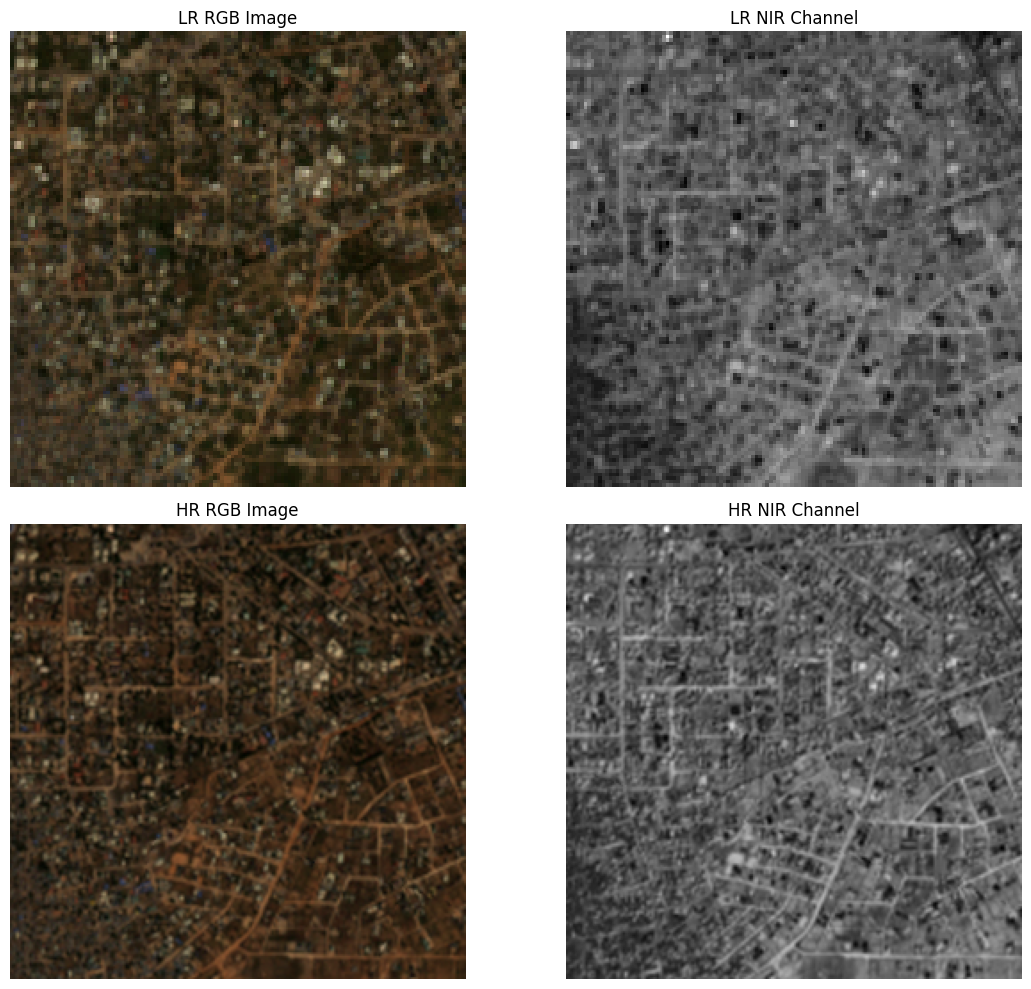

c:\Users\arsal\Desktop\leafs\.conda\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\arsal\Desktop\leafs\.conda\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



Epoch 1/15


Validation Epoch 1: 100%|██████████| 2/2 [00:29<00:00, 14.83s/it, Val_D_loss=0.693, Val_G_loss=0.977]


Epoch [1] Validation: D_loss: 0.6931, G_loss: 1.0299


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.5..1.466572].


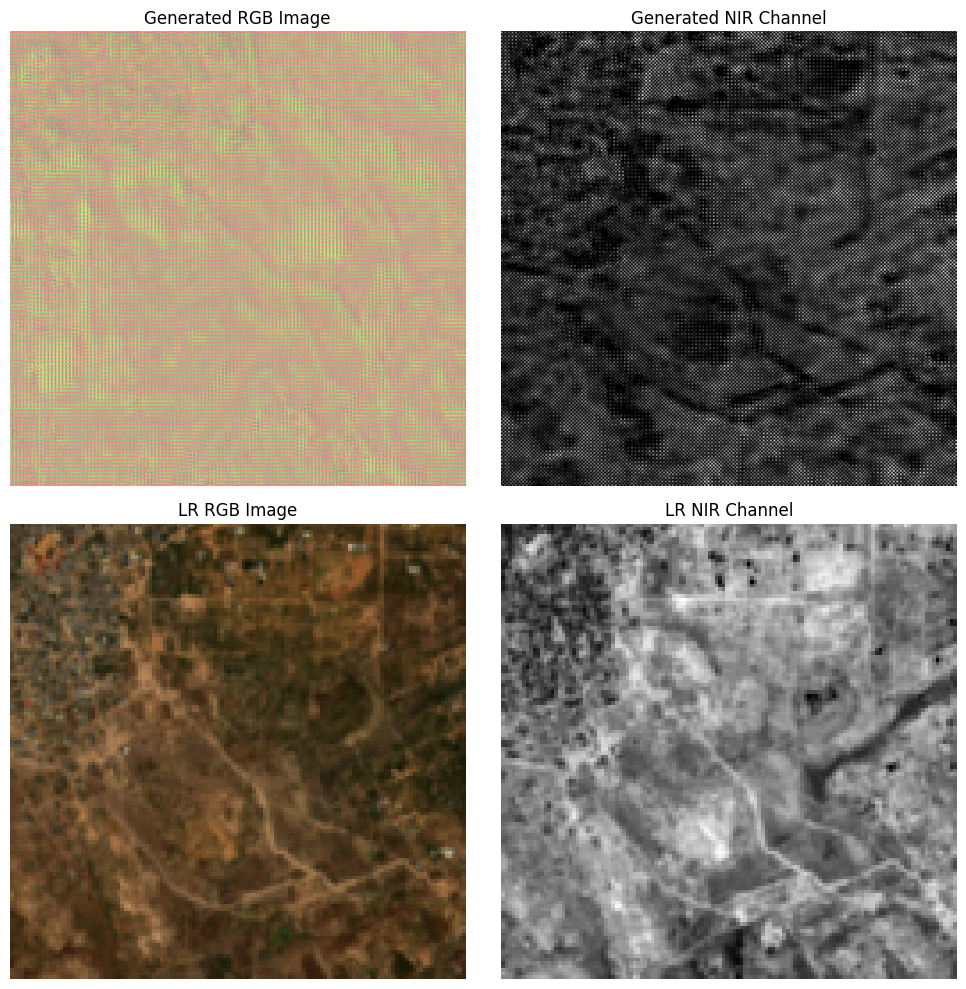


Epoch 2/15


Validation Epoch 2:   0%|          | 0/2 [00:06<?, ?it/s]


KeyboardInterrupt: 

In [12]:
print('test')
main()